In [4]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.


In [7]:
base_image_dir = os.path.join('/Users/ankitmehani/VisualStudio/diabetic-retinopathy-detection/')

df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))


df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [9]:
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['level'].map(diagnosis_dict_binary.get)
df['type'] = df['level'].map(diagnosis_dict.get)
df.sample(10)

,image,level,binary_type,type
8609,10810_right,0,No_DR,No_DR
22298,28118_left,2,DR,Moderate
9999,12612_right,3,DR,Severe
33532,42364_left,1,DR,Mild
18413,23183_right,2,DR,Moderate
33966,42941_left,0,No_DR,No_DR
6373,8002_right,0,No_DR,No_DR
16568,20797_left,2,DR,Moderate
4370,5505_left,3,DR,Severe
12506,15674_left,0,No_DR,No_DR


<Axes: ylabel='type'>

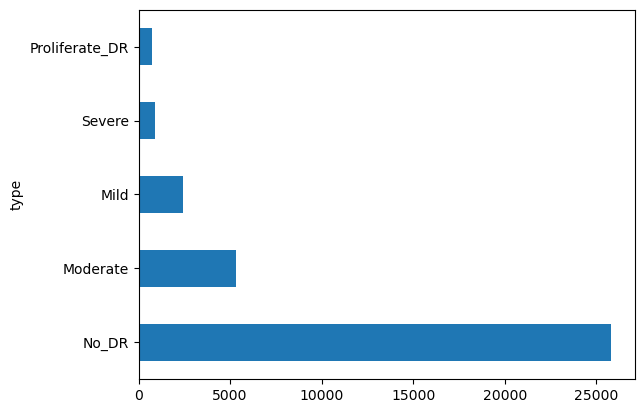

In [10]:
df['type'].value_counts().plot(kind='barh')

In [11]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
type
No_DR             18067
Moderate           3704
Mild               1710
Severe              611
Proliferate_DR      496
Name: count, dtype: int64 

For Testing Dataset :
type
No_DR             3871
Moderate           794
Mild               367
Severe             131
Proliferate_DR     106
Name: count, dtype: int64 

For Validation Dataset :
type
No_DR             3872
Moderate           794
Mild               366
Severe             131
Proliferate_DR     106
Name: count, dtype: int64 



In [14]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [15]:
train.sample(10)

,image,level,binary_type,type
27920,35367_left,0,No_DR,No_DR
18326,23084_left,0,No_DR,No_DR
22956,29003_left,0,No_DR,No_DR
12471,15638_right,0,No_DR,No_DR
33880,42821_left,0,No_DR,No_DR
19233,24257_right,0,No_DR,No_DR
20813,26235_right,0,No_DR,No_DR
35104,44328_left,0,No_DR,No_DR
20182,25456_left,0,No_DR,No_DR
11058,13891_left,1,DR,Mild


In [17]:
base_image_dir = os.path.join('/Users/ankitmehani/VisualStudio/diabetic-retinopathy-detection/train/')
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".jpeg"
    srcfile = os.path.join(base_image_dir, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".jpeg"
    srcfile = os.path.join(base_image_dir, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".jpeg"
    srcfile = os.path.join(base_image_dir, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [18]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 24588 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.


### Convolutional neural network (CNN) model using TensorFlow's Keras API. The model consists of several convolutional layers followed by max-pooling layers, batch normalization layers, and dense layers. It is designed to process images with a size of 224x224 pixels and three color channels (RGB). The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy as the metric. It is then trained using training data (train_batches) for 15 epochs with validation data (val_batches). The goal is to learn features from the input images and classify them into one of two categories using softmax activation in the output layer.

In [20]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=15,
                    validation_data=val_batches)

Epoch 1/15


/Users/ankitmehani/Downloads/Notebooks/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-01 15:51:41.254622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 3:02:55 14s/step - acc: 0.4688 - loss: 0.9541

2024-04-01 15:51:42.800539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 1610s 2s/step - acc: 0.7018 - loss: 0.6332 - val_acc: 0.7343 - val_loss: 0.5679
Epoch 2/15


2024-04-01 16:18:30.577304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:55:04 14s/step - acc: 0.7188 - loss: 0.5847

2024-04-01 16:18:32.475035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 1592s 2s/step - acc: 0.7384 - loss: 0.5681 - val_acc: 0.7366 - val_loss: 0.5614
Epoch 3/15


2024-04-01 16:45:02.250446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:51:13 13s/step - acc: 0.7500 - loss: 0.6023

2024-04-01 16:45:03.935280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 3761s 5s/step - acc: 0.7369 - loss: 0.5600 - val_acc: 0.7379 - val_loss: 0.5579
Epoch 4/15


2024-04-01 17:47:41.760488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:56:12 14s/step - acc: 0.8438 - loss: 0.4276

2024-04-01 17:47:45.349255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 1597s 2s/step - acc: 0.7419 - loss: 0.5482 - val_acc: 0.7370 - val_loss: 0.5562
Epoch 5/15


2024-04-01 18:14:18.634438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:54:49 14s/step - acc: 0.7188 - loss: 0.5262

2024-04-01 18:14:22.036884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 6016s 8s/step - acc: 0.7377 - loss: 0.5525 - val_acc: 0.7383 - val_loss: 0.5539
Epoch 6/15


2024-04-01 19:54:36.273405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:52:46 13s/step - acc: 0.7188 - loss: 0.5382

2024-04-01 19:54:38.002398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 5927s 8s/step - acc: 0.7414 - loss: 0.5500 - val_acc: 0.7404 - val_loss: 0.5515
Epoch 7/15


2024-04-01 21:33:23.051748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:50:44 13s/step - acc: 0.7812 - loss: 0.5071

2024-04-01 21:33:24.610735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 6802s 9s/step - acc: 0.7393 - loss: 0.5481 - val_acc: 0.7370 - val_loss: 0.5514
Epoch 8/15


2024-04-01 23:26:44.455344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:49:56 13s/step - acc: 0.8438 - loss: 0.4595

2024-04-01 23:26:46.108599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 2430s 3s/step - acc: 0.7464 - loss: 0.5419 - val_acc: 0.7373 - val_loss: 0.5492
Epoch 9/15


2024-04-02 00:07:15.721299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 00:07:28.367553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 2712s 3s/step - acc: 0.7480 - loss: 0.5356 - val_acc: 0.7351 - val_loss: 0.5499
Epoch 10/15


2024-04-02 00:52:27.167136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 00:52:38.272810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 2293s 3s/step - acc: 0.7483 - loss: 0.5357 - val_acc: 0.7370 - val_loss: 0.5510
Epoch 11/15


2024-04-02 01:30:39.574036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:52:38 13s/step - acc: 0.7812 - loss: 0.4836

2024-04-02 01:30:41.279976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 1600s 2s/step - acc: 0.7490 - loss: 0.5335 - val_acc: 0.7400 - val_loss: 0.5478
Epoch 12/15


2024-04-02 01:57:18.093576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:55:26 14s/step - acc: 0.7812 - loss: 0.4907

2024-04-02 01:57:21.450362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 1593s 2s/step - acc: 0.7508 - loss: 0.5284 - val_acc: 0.7385 - val_loss: 0.5482
Epoch 13/15


2024-04-02 02:23:51.960502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:49:29 13s/step - acc: 0.7500 - loss: 0.4793

2024-04-02 02:23:53.660114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 6950s 9s/step - acc: 0.7527 - loss: 0.5271 - val_acc: 0.7411 - val_loss: 0.5479
Epoch 14/15


2024-04-02 04:19:42.323340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:49:46 13s/step - acc: 0.7188 - loss: 0.5261

2024-04-02 04:19:44.021821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 10005s 13s/step - acc: 0.7483 - loss: 0.5298 - val_acc: 0.7411 - val_loss: 0.5494
Epoch 15/15


2024-04-02 07:06:26.429330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


  1/769 ━━━━━━━━━━━━━━━━━━━━ 2:55:12 14s/step - acc: 0.6562 - loss: 0.6128

2024-04-02 07:06:29.796852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


769/769 ━━━━━━━━━━━━━━━━━━━━ 8721s 11s/step - acc: 0.7593 - loss: 0.5199 - val_acc: 0.7392 - val_loss: 0.5487


In [22]:
model

<Sequential name=sequential_1, built=True>

In [23]:
model.save('64x3-CNN.keras')

In [25]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Loss:", loss)
print("Accuracy:", acc)


/Users/ankitmehani/Downloads/Notebooks/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - acc: 0.4596 - loss: 0.8261
Loss: 0.5488453507423401
Accuracy: 0.7397988438606262


In [29]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/77/df/b56175c3fb5bc058774bdcf35f5a71cf9c3c5b909f98a1c688eb71cd3b1f/opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 41.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [40]:
import cv2

In [59]:
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.keras")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        #print('Diabetic Retinopathy Not Detected')
        return False
    else:
        #print('Diabetic Retinopathy Detected')
        return True

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


True

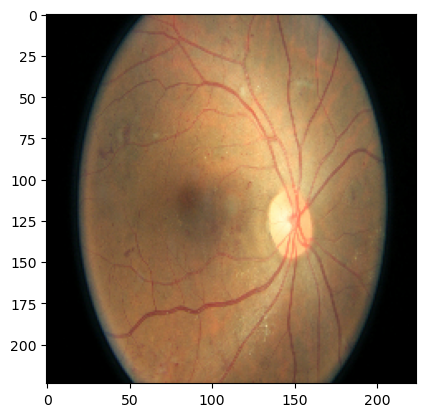

In [60]:
predict_class('/Users/ankitmehani/VisualStudio/MSIN0097_PredictiveAnalytics_2024/test/DR/687_left.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━

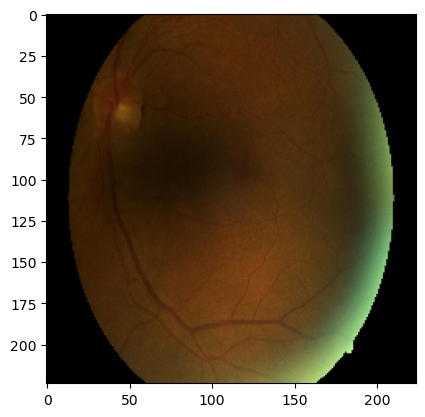

In [61]:
# Predictions for DR Images
folder_path = '/Users/ankitmehani/VisualStudio/MSIN0097_PredictiveAnalytics_2024/test/DR/'
correct_predictions = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.jpeg') or filename.endswith('.jpg'):
        image_path = os.path.join(folder_path, filename)
        if predict_class(image_path):
            correct_predictions += 1

total_images = len(os.listdir(folder_path))
incorrect_predictions = total_images - correct_predictions

print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")

In [63]:
# Changing function for Non DR 
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.keras")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        #print('Diabetic Retinopathy Not Detected')
        return True
    else:
        #print('Diabetic Retinopathy Detected')
        return False

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

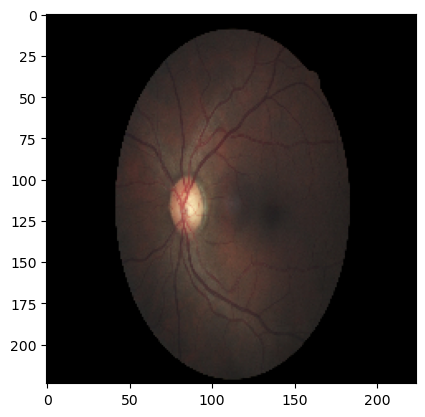

In [64]:
# Predictions for Non DR Images

folder_path = '/Users/ankitmehani/VisualStudio/MSIN0097_PredictiveAnalytics_2024/test/No_DR/'
correct_predictions = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.jpeg') or filename.endswith('.jpg'):
        image_path = os.path.join(folder_path, filename)
        if predict_class(image_path):
            correct_predictions += 1

total_images = len(os.listdir(folder_path))
incorrect_predictions = total_images - correct_predictions

print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Diabetic Retinopathy Not Detected


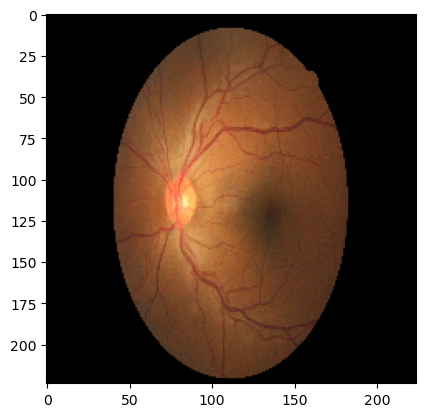

In [38]:
predict_class('/Users/ankitmehani/VisualStudio/MSIN0097_PredictiveAnalytics_2024/test/No_DR/17_left.jpeg')